

# Table of Content
1.   Data Retrieval
 * Understanding the data
2.   Training and validation the dataset
 * Creation of model
 * MCMC Sampling
3.   Prediction using the model 





In [21]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-6nl2iwv9
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-6nl2iwv9
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=1eed1f1b8d8993309c418776f5855fd7fb51b37cedcd6d15ca82dbe66921ea52
  Stored in directory: /tmp/pip-ephem-wheel-cache-3geqg60z/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference


Importing the essential modules

In [22]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

In [23]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

## Evidence = P(Data|Model)

##      $P(\theta|Data,Model) ~=~ P(Data|\theta,Model)P(\theta)$



#### Data retrieval


In [24]:
# Using the covid19_inference to download data from John Hopkins University (JHU) 
jhu = cov19.data_retrieval.JHU()  
jhu.download_all_available_data()

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [25]:
# getting the Rwandan confirmed, recovered, deaths numbers from JHU data
Rwanda_data = jhu.get_total_confirmed_deaths_recovered(country = "Rwanda")

In [26]:
# Check if the date column has null values
Rwanda_data.reset_index()['date'].isna().sum()

0

In [27]:
#Checking for missing values.
Rwanda_data.isnull().sum()

confirmed    0
deaths       0
recovered    0
dtype: int64

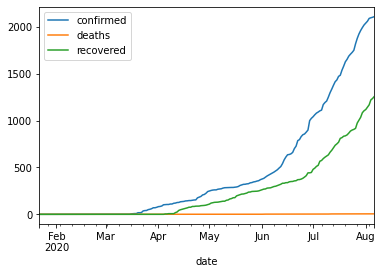

In [28]:
Rwanda_data.plot()

In [30]:
#Confirming when the number of cases hit 100 in rwanda
Rwanda_data_df = Rwanda_data[Rwanda_data['confirmed']>100].head()
Rwanda_data_df

,confirmed,deaths,recovered
date,,,
2020-04-04,102,0,0
2020-04-05,104,0,4
2020-04-06,105,0,4
2020-04-07,105,0,7
2020-04-08,110,0,7


When the number of covid19 cases in Rwanda  reached 100  was *4th April 2020*

Getting all new cases and the total (cumulative) cases for the for country Rwanda

In [31]:
bd = datetime.datetime(2020, 4, 4)  # For the date filter
ed = datetime.datetime.now()
#ed = datetime.datetime(2020, 7, 25)

In [32]:
# geting the number of new cases for each day
total_cases_obs = jhu.get_total(
    value="confirmed", country= "Rwanda", data_begin=bd, data_end=ed)
# geting the number of new cases for each day
new_cases_obs = jhu.get_new(
    value="confirmed", country= "Rwanda", data_begin=bd, data_end=ed)

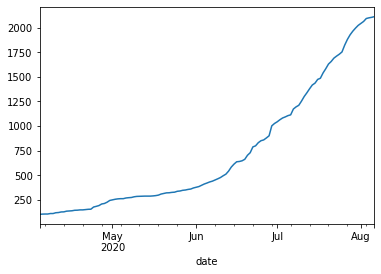

In [33]:
total_cases_obs.plot()

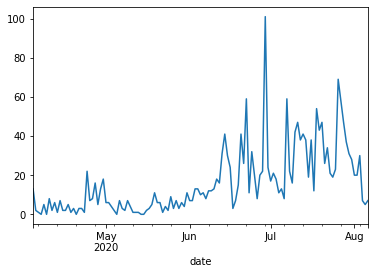

In [34]:
new_cases_obs.plot()

## Creation of  the model
Bayesian inference is the process of fitting a probability model to a set of data and summarizing the result by a probability distribution on the parameters of the model and on unobserved quantities such as predictions for new observations.

In [35]:
#Spliting the dataset into test data and train data
from sklearn.model_selection import train_test_split
X = new_cases_obs
X_train, X_test = train_test_split(X, test_size=0.095, shuffle=False)

In [36]:
X_test.head()

date
2020-07-26    69
2020-07-27    58
2020-07-28    47
2020-07-29    37
2020-07-30    31
Name: confirmed, dtype: int64

Setting the priors for the change points.

In [ ]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 12

# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 4, 20)
prior_date_strong_dist_begin = datetime.datetime(2020, 4, 30)
prior_date_contact_ban_begin = datetime.datetime(2020, 5, 4)

In [ ]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

In [ ]:
'''
Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.
'''

params_model = dict(
    new_cases_obs=X_train[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 14 days
pr_delay = 14

In [ ]:
'''
The model is specified in a context. Each function in this context
has access to the model parameters set.
'''

with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  


## MCMC sampling



In [ ]:
'''
After the model is built, it is sampled using an MCMC sampler.
'''
trace = pm.sample(model=this_model, tune=500, draws=100, init="advi+adapt_diag")

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 529.67:   8%|▊         | 16896/200000 [02:30<27:07, 112.50it/s]
Convergence achieved at 16900
INFO     [pymc3.variational.inference] Convergence achieved at 16900
Interrupted at 16,899 [8%]: Average Loss = 569.83
INFO     [pymc3.variational.inference] Interrupted at 16,899 [8%]: Average Loss = 569.83
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, wee


### Plotting



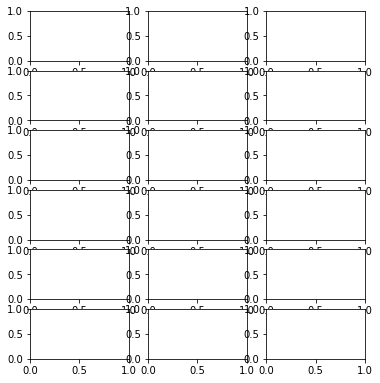

In [ ]:
'''
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions
'''
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))



In [ ]:
# Getting the free Random Variables
varnames = this_model.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)


Possible varnames are :
['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


In [ ]:

# Plotting them
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])



In [ ]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])


In [ ]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])



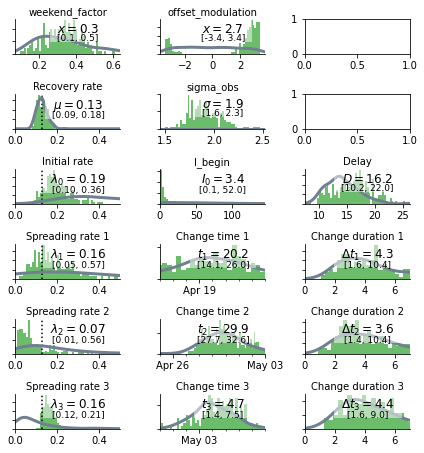

In [ ]:
fig.tight_layout()
fig #To print in jupyter notebook



### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


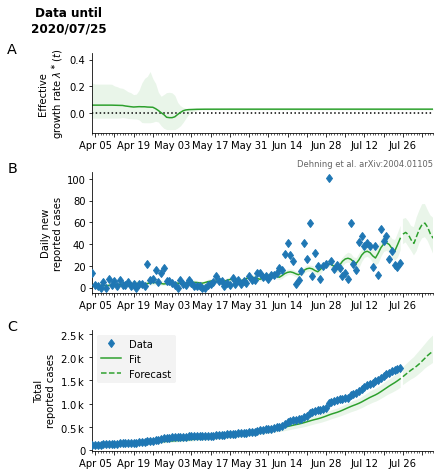

In [ ]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=100)

In [ ]:
# Getting the forecast values from the model
fcast_x, fcast_y = cov19.plot._get_array_from_trace_via_date(this_model, trace, 'new_cases', this_model.fcast_begin, this_model.fcast_end )

In [ ]:
# Evaluating the models performance i.e how accurate is the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mean_squared_error(X_test.head(12), fcast_x[0])**0.5

31.262745535257498

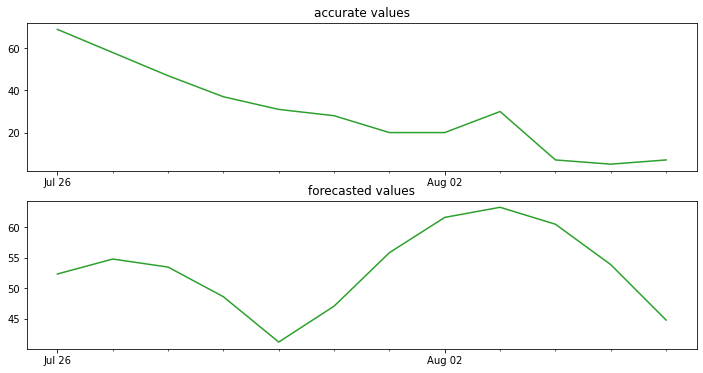

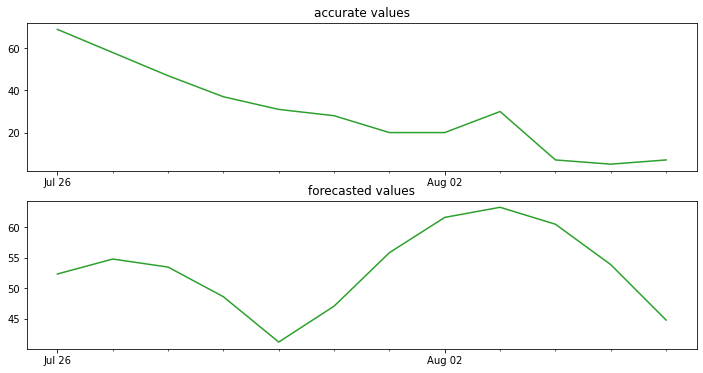

In [ ]:
# Create a multiplot
fig1, axes1 = plt.subplots(2,1, figsize=(12,6))

# Visual representation of the models performance
cov19.plot._timeseries(x=X_test.head(25).index, y=X_test.head(25), ax=axes1[0], what='model')
cov19.plot._timeseries(x=fcast_y, y=fcast_x[0],ax=axes1[1], what='model')

# Label the plots

axes1[0].set_title("accurate values")

axes1[1].set_title("forecasted values")

# Show the figure
fig1.show()
fig1

## Prediction

In [37]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10 #prediction days

# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 4, 20)
prior_date_strong_dist_begin = datetime.datetime(2020, 4, 30)
prior_date_contact_ban_begin = datetime.datetime(2020, 5, 4)

change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

In [38]:
'''
Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.
'''

params_model = dict(
    new_cases_obs=X[:], #where X = new_cases_obs
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 14 days
pr_delay = 14



In [39]:
'''
The model is specified in a context. Each function in this context
has access to the model parameters set.
'''

with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

### MCMC sampling

In [40]:
'''
After the model is built, it is sampled using an MCMC sampler.
'''
trace = pm.sample(model=this_model, tune=500, draws=100, init="advi+adapt_diag")

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 600.77:  11%

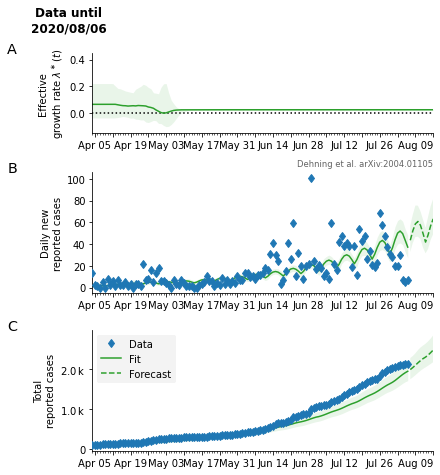

In [41]:
"""### Timeseries
    timeseries overview, for now needs an offset variable to get cumulative cases
"""
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=100)